In [2]:
# !pip install numpy opencv-python matplotlib PyWavelets

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
import os
import copy

# Frame Extraction

In [3]:
def extract_frames(video_path, output_folder):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    video_capture = cv2.VideoCapture(video_path)
    fps = video_capture.get(cv2.CAP_PROP_FPS)

    if not video_capture.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    
    frame_count = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break

        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.png")
        cv2.imwrite(frame_filename, frame)
        
        print(f"Extracted frame {frame_count}")
        frame_count += 1
    
    video_capture.release()
    print("Frame extraction completed.")
    return fps

frame_rate = extract_frames('test_video.mp4', 'extracted_frames')


Extracted frame 0
Extracted frame 1
Extracted frame 2
Extracted frame 3
Extracted frame 4
Extracted frame 5
Extracted frame 6
Extracted frame 7
Extracted frame 8
Extracted frame 9
Extracted frame 10
Extracted frame 11
Extracted frame 12
Extracted frame 13
Extracted frame 14
Extracted frame 15
Extracted frame 16
Extracted frame 17
Extracted frame 18
Extracted frame 19
Extracted frame 20
Extracted frame 21
Extracted frame 22
Extracted frame 23
Extracted frame 24
Extracted frame 25
Extracted frame 26
Extracted frame 27
Extracted frame 28
Extracted frame 29
Extracted frame 30
Extracted frame 31
Extracted frame 32
Extracted frame 33
Extracted frame 34
Extracted frame 35
Extracted frame 36
Extracted frame 37
Extracted frame 38
Extracted frame 39
Extracted frame 40
Extracted frame 41
Extracted frame 42
Extracted frame 43
Extracted frame 44
Extracted frame 45
Extracted frame 46
Extracted frame 47
Extracted frame 48
Extracted frame 49
Extracted frame 50
Extracted frame 51
Extracted frame 52
Ext

# Helper Functions


## Watermark

In [4]:
def create_watermark(shape):
    return np.random.randint(0, 2, shape, dtype=np.uint8)

## DWT

In [5]:
def dwt_transform(image, wavelet = 'haar'):
    
    b, g, r = cv2.split(image)

    coeffsb = pywt.dwt2(b, wavelet)
    coeffsg = pywt.dwt2(g, wavelet)
    coeffsr = pywt.dwt2(r, wavelet)
    
    LL = cv2.merge((coeffsb[0], coeffsg[0], coeffsr[0]))
    LH = cv2.merge((coeffsb[1][0], coeffsg[1][0], coeffsr[1][0]))
    HL = cv2.merge((coeffsb[1][1], coeffsg[1][1], coeffsr[1][1]))
    HH = cv2.merge((coeffsb[1][2], coeffsg[1][2], coeffsr[1][2]))
    
    return (LL, (LH, HL, HH))

def dwt_transform_inverse(coeffs , wavelet = 'haar'):

    coeffsB = (coeffs[0][:, :, 0], 
               (coeffs[1][0][:, :, 0],
               coeffs[1][1][:, :, 0],
               coeffs[1][1][:, :, 0]))
    coeffsG = (coeffs[0][:, : , 1],
               (coeffs[1][0][:, :, 1],
                coeffs[1][1][:, :, 1],
                coeffs[1][1][:, :, 1]))
    coeffsR = (coeffs[0][:, : , 2],
               (coeffs[1][0][:, :, 2],
                coeffs[1][1][:, :, 2],
                coeffs[1][1][:, :, 2]))
    
    Ib = pywt.idwt2(coeffsB, wavelet=wavelet)
    Ig = pywt.idwt2(coeffsG, wavelet=wavelet)
    Ir = pywt.idwt2(coeffsR, wavelet=wavelet)

    return cv2.merge((Ib, Ig, Ir))

## Chaotic Map

In [6]:
def CFold_1(Z):
        return Z.real % 1 + (Z.imag % 1) * 1j

def compute_Z1(a, c1, Z1, Z2):
    return CFold_1(a * ((Z1 / Z2)**2) + c1) 

def compute_Z2(b, c2, Z1, Z2):    
    return CFold_1(b * ((Z2 / Z1)**2) + c2) 

def compute_x_y(Z1, Z2, rcB4, ccB4):
    return (int(np.floor(Z1.real * (10**14)) % rcB4), 
            int(np.floor(Z2.imag * (10**14)) % ccB4))

def compute_channel(Z2, channels = 3):
    return int(np.floor(Z2.real * (10**14)) % channels)

def compute_B(Z2):
    return int(np.floor(Z2.imag * (10**14)) % 2)

## Embedding Conditions

In [7]:
def condition_for_zero(Wij, U, T):
    return (Wij == 0  and 
            np.abs(U[0, 0]) > np.abs(U[1, 0]) and 
            np.abs(U[1, 0]) - np.abs(U[0, 0]) < T)

def condition_for_one(Wij, U, T):
    return (Wij == 1 and  
            np.abs(U[0, 0]) < np.abs(U[1, 0]) and 
            np.abs(U[1, 0]) - np.abs(U[0, 0]) > T)

## Inverse SVD

In [8]:
def inverse_svd(U, S, Vt):
    S = np.diag(S)
    S_full = np.zeros((U.shape[0], Vt.shape[1]))
    S_full[:S.shape[0], :S.shape[1]] = S
    return U @ S_full @ Vt

# Embedding and Extraction Function

## Original Algorithm

In [52]:
# def embedding_extraction_function(I = None, W = None, param = None, extract = True):

#     if I is None:
#         raise Exception("Frame not provided.")
#     elif W is None:
#         raise Exception("Watermark not provided for Embedding/Extraction.")
#     elif param is None:
#         raise Exception("Parameters not provided.")

#     LL, (LH, HL, HH) = dwt_transform(I)    
#     rc, cc, channels = LL.shape
#     rcB4, ccB4 = rc // 4, cc // 4

#     mask = np.zeros((rcB4, ccB4, channels))     

#     for i in range(param['W_shape'][0]):
#         for j in range(param['W_shape'][1]):
            
#             while True:
                
                # param['Z1_history'].append(
                #     compute_Z1(a = param['a'], 
                #                c1 = param['c1'], 
                #                Z1 = param['Z1_history'][-1], 
                #                Z2 = param['Z2_history'][-1]))
                
                # param['Z2_history'].append(
                #     compute_Z2(b = param['b'], 
                #                c2 = param['c2'], 
                #                Z1 = param['Z1_history'][-1], 
                #                Z2 = param['Z2_history'][-1]))
    
                # x, y = compute_x_y(Z1 = param['Z1_history'][-1], 
                #                    Z2 = param['Z2_history'][-1], 
                #                    rcB4 = rcB4, 
                #                    ccB4 = ccB4)
    
                # channel = compute_channel(Z2 = param['Z2_history'][-1])
    
                # B = compute_B(Z2 = param['Z2_history'][-1])
                
#                 if mask[x, y, channel] == 0:
#                     break

#         block = LL[x * 4 : x * 4 + 4, 
#                     y * 4 : y * 4 + 4,
#                     channel]
        
#         U, S, Vt = np.linalg.svd(block, full_matrices = True)

#         # EMBEDDING
#         if not extract:
            
#             meanV = (np.abs(U[0, 0]) + np.abs(U[1, 0])) / 2

#             # if condition_for_zero(W[i, j], U, param['T']):
#             if W[i, j] == 0:
#                 U[0, 0] = np.sign(U[0, 0]) * (meanV + param['T'] / 2)
#                 U[1, 0] = np.sign(U[1, 0]) * (meanV - param['T'] / 2)

#             # XOR
#             # if Wij != B then Wij = 1 and block below executes
#             W[i, j] = int(W[i, j]) ^ B 
            
#             # if condition_for_one(W[i, j], U, param['T']): 
#             if W[i, j] == 1:
#                 U[0, 0] = np.sign(U[0, 0]) * (meanV - param['T'] / 2)
#                 U[1, 0] = np.sign(U[1, 0]) * (meanV + param['T'] / 2)

#             LL[x * 4 : x * 4 + 4, 
#                y * 4 : y * 4 + 4,
#                channel] = inverse_svd(U, S, Vt)

#         # EXTRACTION
#         if extract:

#             if np.abs(U[0, 0]) > np.abs(U[1, 0]):
#                 W[i, j] = 0
#             else:
#                 W[i, j] = 1

#             W[i, j] = int(W[i, j]) ^ B

#         mask[x, y, channel] = 1
    
#     if not extract:
#         return dwt_transform_inverse((LL, (LH, HL, HH)))
#     elif extract:
#         return W

        

## Modified Algorithm

In [103]:
def embedding_extraction_function(I=None, W=None, param=None, extract=True):
    if I is None:
        raise Exception("Frame not provided.")
    elif W is None:
        raise Exception("Watermark not provided for Embedding/Extraction.")
    elif param is None:
        raise Exception("Parameters not provided.")

    LL, (LH, HL, HH) = dwt_transform(I)    
    rc, cc, channels = LL.shape
    rcB4, ccB4 = rc // 4, cc // 4

    mask = np.zeros((rcB4, ccB4, channels))     


    epsilon = 0#1e-6

    for i in range(param['W_shape'][0]):
        for j in range(param['W_shape'][1]):
            while True:
                Z1_next = compute_Z1(a=param['a'], 
                                     c1=param['c1'], 
                                     Z1=param['Z1_history'][-1], 
                                     Z2=param['Z2_history'][-1])
                Z2_next = compute_Z2(b=param['b'], 
                                     c2=param['c2'], 
                                     Z1=param['Z1_history'][-1], 
                                     Z2=param['Z2_history'][-1])

                param['Z1_history'].append(Z1_next)
                param['Z2_history'].append(Z2_next)

                x, y = compute_x_y(Z1=Z1_next, 
                                   Z2=Z2_next, 
                                   rcB4=rcB4, 
                                   ccB4=ccB4)

                channel = compute_channel(Z2=Z2_next)

                B = compute_B(Z2=Z2_next)
                
                if mask[x, y, channel] == 0:
                    break

            block = LL[x * 4: x * 4 + 4, 
                       y * 4: y * 4 + 4,
                       channel]
            
            U, S, Vt = np.linalg.svd(block, full_matrices=False)

            # EMBEDDING
            if not extract:
                meanV = (np.abs(U[0, 0]) + np.abs(U[1, 0])) / 2

                # XOR with B
                Wij = W[i, j] ^ B

                if Wij == 0:
                    U[0, 0] = np.sign(U[0, 0]) * (meanV + param['T'] / 2)
                    U[1, 0] = np.sign(U[1, 0]) * (meanV - param['T'] / 2)
                else:
                    U[0, 0] = np.sign(U[0, 0]) * (meanV - param['T'] / 2)
                    U[1, 0] = np.sign(U[1, 0]) * (meanV + param['T'] / 2)

                LL[x * 4: x * 4 + 4, 
                   y * 4: y * 4 + 4,
                   channel] = inverse_svd(U, S, Vt)

            # EXTRACTION
            else:
                if np.abs(U[0, 0]) - np.abs(U[1, 0]) > epsilon:
                    extracted_bit = 0
                else:
                    extracted_bit = 1

                B = compute_B(Z2=Z2_next)
                W[i, j] = extracted_bit ^ B

            mask[x, y, channel] = 1
        
    if not extract:
        return dwt_transform_inverse((LL, (LH, HL, HH)))
    elif extract:
        return W


# Embed Frames

In [104]:
def embed(frames_folder, param):

    frame_paths = [frm for frm in os.listdir(frames_folder) if frm.endswith(".png")]
    frame_paths.sort()
    
    param_copy = copy.deepcopy(param)
    
    watermark = create_watermark(shape = param_copy['W_shape'])

    embeded_frames = []

    for frame_path in frame_paths:
        path = os.path.join(frames_folder, frame_path)

        embeded_frames.append(
            embedding_extraction_function(
                I = cv2.imread(path), 
                W = watermark,
                param = param_copy,
                extract = False))
    
    print("Embedding Complete")
    
    return embeded_frames, watermark, param_copy 

In [105]:
param_initial = {
        'a' : 10.7, 
        'b' : 11.2,
        'Z1_history' : [0.83 + 0.35j],
        'Z2_history' : [0.67 + 0.54j],
        'c1' : 0.53 + 0.26j, 
        'c2' : 0.83 + 0.35j, 
        'T' : 0.25,
        'W_shape' : (10, 10)
    }


embeded_frames, watermark, param_embed = embed(frames_folder='extracted_frames', 
                                               param=param_initial)

Embedding Complete


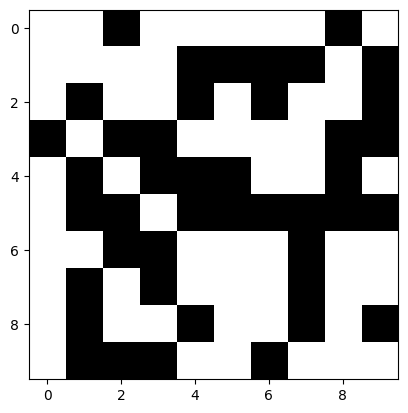

In [106]:
plt.imshow(watermark, cmap = plt.cm.gray)

In [107]:
watermark

array([[1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 1, 0],
       [1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       [1, 0, 1, 1, 0, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 1, 0, 1, 1, 1]], dtype=uint8)

In [108]:
len(embeded_frames)

337

In [109]:
embeded_frames[0].shape

(720, 1280, 3)

In [110]:
param_embed

{'a': 10.7,
 'b': 11.2,
 'Z1_history': [(0.83+0.35j),
  (0.47221676048767236+0.04583567775664754j),
  (0.8824359434741684+0.45491761475240455j),
  (0.7713142469770968+0.7239088291549063j),
  (0.25198633229538103+0.33491098261231067j),
  (0.12688534600673185+0.9730688637703535j),
  (0.2476843545731482+0.14381032201392685j),
  (0.9833761404726401+0.25107374335485577j),
  (0.80831475701968+0.5735280000332068j),
  (0.4721305605920829+0.08764333551914039j),
  (0.165317060446025+0.9286416205813275j),
  (0.3266903227214315+0.023675534221929695j),
  (0.3374353094748871+0.412258731649941j),
  (0.031365583682372744+0.6120184812202139j),
  (0.04939699469964065+0.849317546674631j),
  (0.15422220676173382+0.6102646091325967j),
  (0.8817675079789051+0.8501369375590162j),
  (0.5029806917195252+0.3676132227229294j),
  (0.9498095789461574+0.6847223264103786j),
  (0.9632527250259244+0.5362900568410396j),
  (0.48508919758653235+0.018506674932774914j),
  (0.5391824178952866+0.7672576449978967j),
  (0.1589

In [111]:
def save_frames(frames, output_folder):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for frame_count, frame in enumerate(frames):
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.png")
        cv2.imwrite(frame_filename, frame)

        print(f"Saved Frame {frame_count}")

In [112]:
save_frames(frames = embeded_frames, 
            output_folder='embeded_frames')

Saved Frame 0
Saved Frame 1
Saved Frame 2
Saved Frame 3
Saved Frame 4
Saved Frame 5
Saved Frame 6
Saved Frame 7
Saved Frame 8
Saved Frame 9
Saved Frame 10
Saved Frame 11
Saved Frame 12
Saved Frame 13
Saved Frame 14
Saved Frame 15
Saved Frame 16
Saved Frame 17
Saved Frame 18
Saved Frame 19
Saved Frame 20
Saved Frame 21
Saved Frame 22
Saved Frame 23
Saved Frame 24
Saved Frame 25
Saved Frame 26
Saved Frame 27
Saved Frame 28
Saved Frame 29
Saved Frame 30
Saved Frame 31
Saved Frame 32
Saved Frame 33
Saved Frame 34
Saved Frame 35
Saved Frame 36
Saved Frame 37
Saved Frame 38
Saved Frame 39
Saved Frame 40
Saved Frame 41
Saved Frame 42
Saved Frame 43
Saved Frame 44
Saved Frame 45
Saved Frame 46
Saved Frame 47
Saved Frame 48
Saved Frame 49
Saved Frame 50
Saved Frame 51
Saved Frame 52
Saved Frame 53
Saved Frame 54
Saved Frame 55
Saved Frame 56
Saved Frame 57
Saved Frame 58
Saved Frame 59
Saved Frame 60
Saved Frame 61
Saved Frame 62
Saved Frame 63
Saved Frame 64
Saved Frame 65
Saved Frame 66
Saved

# Watermark Extraction

In [113]:
def extract(frames_folder, param):

    frame_paths = [frm for frm in os.listdir(frames_folder) if frm.endswith(".png")]
    frame_paths.sort()
    
    param_copy = copy.deepcopy(param)
    
    watermarks_extracted = [] 

    for frame_path in frame_paths:
        path = os.path.join(frames_folder, frame_path)
        watermarks_extracted.append(embedding_extraction_function(I = cv2.imread(path), 
                                                            W = np.zeros(param['W_shape'], dtype=np.uint8),
                                                            param = param_copy))
        
    return watermarks_extracted, param_copy 

In [114]:
Ws_extracted, param_extract = extract(frames_folder='embeded_frames', 
                                      param = param_initial)

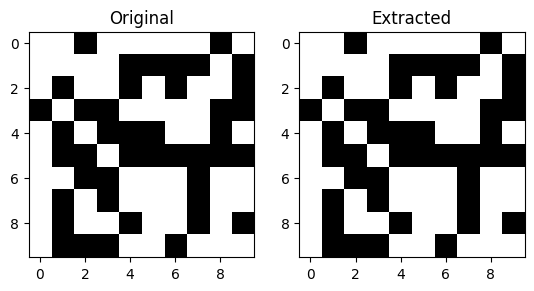

In [115]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(watermark, cmap = 'gray')
axs[0].set_title("Original")
axs[1].imshow(Ws_extracted[-1], cmap = 'gray')
axs[1].set_title("Extracted")
plt.show()

# Save as Video

In [116]:
def create_video_from_images(image_folder, output_video_path, frame_rate):
    
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort()  
    
    if not images:
        print("No images found in the folder.")
        return
    
    first_image_path = os.path.join(image_folder, images[0])
    frame = cv2.imread(first_image_path)
    height, width, channels = frame.shape
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
    video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (width, height))
    
    for image in images:
        image_path = os.path.join(image_folder, image)
        frame = cv2.imread(image_path)
        
        if frame is None:
            print(f"Error reading image {image_path}")
            continue
        
        video_writer.write(frame)
        print(f"Writing frame {image_path}")
    
    video_writer.release()
    print(f"Video creation completed. Saved to {output_video_path}")

create_video_from_images(image_folder='extracted_frames', 
                         output_video_path='embeded_video.mp4', 
                         frame_rate = frame_rate)

Writing frame extracted_frames\frame_0000.png
Writing frame extracted_frames\frame_0001.png
Writing frame extracted_frames\frame_0002.png
Writing frame extracted_frames\frame_0003.png
Writing frame extracted_frames\frame_0004.png
Writing frame extracted_frames\frame_0005.png
Writing frame extracted_frames\frame_0006.png
Writing frame extracted_frames\frame_0007.png
Writing frame extracted_frames\frame_0008.png
Writing frame extracted_frames\frame_0009.png
Writing frame extracted_frames\frame_0010.png
Writing frame extracted_frames\frame_0011.png
Writing frame extracted_frames\frame_0012.png
Writing frame extracted_frames\frame_0013.png
Writing frame extracted_frames\frame_0014.png
Writing frame extracted_frames\frame_0015.png
Writing frame extracted_frames\frame_0016.png
Writing frame extracted_frames\frame_0017.png
Writing frame extracted_frames\frame_0018.png
Writing frame extracted_frames\frame_0019.png
Writing frame extracted_frames\frame_0020.png
Writing frame extracted_frames\fra

# Testing

In [70]:
param_initial

{'a': 10.7,
 'b': 11.2,
 'Z1_history': [(0.83+0.35j)],
 'Z2_history': [(0.67+0.54j)],
 'c1': (0.53+0.26j),
 'c2': (0.83+0.35j),
 'T': 0.25,
 'W_shape': (10, 10)}

In [71]:
param_embed

{'a': 10.7,
 'b': 11.2,
 'Z1_history': [(0.83+0.35j),
  (0.47221676048767236+0.04583567775664754j),
  (0.8824359434741684+0.45491761475240455j),
  (0.7713142469770968+0.7239088291549063j),
  (0.25198633229538103+0.33491098261231067j),
  (0.12688534600673185+0.9730688637703535j),
  (0.2476843545731482+0.14381032201392685j),
  (0.9833761404726401+0.25107374335485577j),
  (0.80831475701968+0.5735280000332068j),
  (0.4721305605920829+0.08764333551914039j),
  (0.165317060446025+0.9286416205813275j),
  (0.3266903227214315+0.023675534221929695j),
  (0.3374353094748871+0.412258731649941j),
  (0.031365583682372744+0.6120184812202139j),
  (0.04939699469964065+0.849317546674631j),
  (0.15422220676173382+0.6102646091325967j),
  (0.8817675079789051+0.8501369375590162j),
  (0.5029806917195252+0.3676132227229294j),
  (0.9498095789461574+0.6847223264103786j),
  (0.9632527250259244+0.5362900568410396j),
  (0.48508919758653235+0.018506674932774914j),
  (0.5391824178952866+0.7672576449978967j),
  (0.1589

In [72]:
param_extract

{'a': 10.7,
 'b': 11.2,
 'Z1_history': [(0.83+0.35j),
  (0.47221676048767236+0.04583567775664754j),
  (0.8824359434741684+0.45491761475240455j),
  (0.7713142469770968+0.7239088291549063j),
  (0.25198633229538103+0.33491098261231067j),
  (0.12688534600673185+0.9730688637703535j),
  (0.2476843545731482+0.14381032201392685j),
  (0.9833761404726401+0.25107374335485577j),
  (0.80831475701968+0.5735280000332068j),
  (0.4721305605920829+0.08764333551914039j),
  (0.165317060446025+0.9286416205813275j),
  (0.3266903227214315+0.023675534221929695j),
  (0.3374353094748871+0.412258731649941j),
  (0.031365583682372744+0.6120184812202139j),
  (0.04939699469964065+0.849317546674631j),
  (0.15422220676173382+0.6102646091325967j),
  (0.8817675079789051+0.8501369375590162j),
  (0.5029806917195252+0.3676132227229294j),
  (0.9498095789461574+0.6847223264103786j),
  (0.9632527250259244+0.5362900568410396j),
  (0.48508919758653235+0.018506674932774914j),
  (0.5391824178952866+0.7672576449978967j),
  (0.1589